This notebook takes the group averaged Efields and uses that as TVB stimulus, to simulate the TMS evoked potential for each group.

In [13]:
import numpy as np
from tvb.simulator.lab import * 
from mpl_toolkits.mplot3d import Axes3D

from simulation import *
from tms_coil import *
from visualise import *
from stimulus import *
from utils import *
from config import *

label_font = 16
title_font = 14
legend_font = 12

%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# for AD
type = 'AD'
subject = config.subjects[type][0]
PATH_TO_SC = config.get_subject_structural_connectivity_path(subject, type)
PATH_TO_TRACT_LENGTHS = config.get_subject_tract_lengths_path(subject, type)
PATH_TO_REGION_LABELS = config.get_region_labels_path('HCP_MMP1')

PATH_TO_TMS_ELECTRIC_FIELD = config.get_group_average_efield_over_atlas_path(type, 'HCP_MMP1', 'magnE')

### Visualise the SC

In [15]:

weights = np.log(np.loadtxt(PATH_TO_SC)+1)
# normalise the SC
weights=(weights-np.min(weights))/(np.max(weights)-np.min(weights))

plt.imshow(np.asarray(weights))
plt.colorbar()
plt.title(f'Normalised SC for {type} subject {subject}', fontsize=title_font)
plt.xlabel('Region', fontsize=label_font)
plt.ylabel('Region', fontsize=label_font)
plt.show()

### Define TVB models

In [16]:
# TVB
dt = 1
neuron_model, heunint, default_cortex, white_matter, white_matter_coupling = get_brain_models(NMM='jansen_rit', 
                                                                                             path_to_SC=PATH_TO_SC,
                                                                                             path_to_region_labels=PATH_TO_REGION_LABELS,
                                                                                             path_to_tract_lenghts=PATH_TO_TRACT_LENGTHS,
                                                                                             dt=dt
                                                                                             )

### Define TMS as stimulus

In [17]:
# using HCP MMP1 atlas
import json
with open(PATH_TO_TMS_ELECTRIC_FIELD, 'r') as f:
    electric_field_strength = json.load(f)

# renaming to match white_matter.region_labels
electric_field_strength = { f'L_{k[3:]}' if 'lh.' in k else f'R_{k[3:]}': v for k, v in electric_field_strength.items()}
# rearranging values and filling with zeros to match white_matter.region_labels order
electric_field_strength = np.array([electric_field_strength[area] if area in electric_field_strength.keys() else 0 for area in white_matter.region_labels])


coil = TMS_coil(type="fig8")
field_scale = 5e1
electric_field_strength = electric_field_strength * field_scale
coil.get_stimulus_distribution(electric_field_strength, white_matter.region_labels)

Region index    Region label    Stimulus weighting
233             L_6d            55.59184432958717
191             L_55b           41.24130607684709
189             L_FEF           37.99668103388786
230             L_1             36.12061762744085
246             L_8Av           33.386476471505055
276             L_i6-8          30.43706705191373
190             L_PEF           28.705715902595603
277             L_s6-8          27.548648552670045
275             L_6a            26.67944970707626
188             L_3b            26.36146484419703
223             L_6ma           25.33436017367348
226             L_7PC           24.068117135237728
252             L_8C            22.029778560017697
262             L_p9-46v        21.678143490026667
231             L_2             21.675371048815066
187             L_4             21.170190345594577
235             L_6v            20.745232958660466
247             L_8Ad           19.9194413473807
263             L_46            19.794214

In [18]:
frequency = 500.0
stimulus_onset = 1e3
duration = 1.5e3

stimulus = get_stimulus(electric_field_strength*-1, white_matter, onset=stimulus_onset, frequency=frequency, duration=duration, type='rTMS', dt=dt)
plot_stimulus(stimulus)

### Define simulator

In [19]:
monitors = get_monitors(["raw"])

rs_sim = simulator.Simulator(model=neuron_model,
                        connectivity=white_matter,
                        coupling=white_matter_coupling,
                        integrator=heunint,
                        monitors=monitors
                        )
rs_sim.configure()


# TMS simulation
tms_sim = simulator.Simulator(model=neuron_model,
                          connectivity=white_matter,
                          coupling=white_matter_coupling,
                          integrator=heunint,
                          monitors=monitors,
                          stimulus=stimulus
                         )
tms_sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: a7eba335-6338-4b00-8c0c-72e4f2e563f2
coupling,SigmoidalJansenRit gid: ad4ead33-c65f-458d-b0b4-bb449e7ef718
gid,UUID('f5de8305-144a-41ed-82db-cbc234aa1979')
initial_conditions,None
integrator,HeunDeterministic gid: f45935ed-e77b-4c19-9b8c-c104211e4b16
model,ExtendedJansenRit gid: 4f17870c-2790-4729-b53f-99e4beb8b9c8
monitors,[]
simulation_length,1000.0


In [20]:
# %%time
def find_roots(x,y):
    s = np.abs(np.diff(np.sign(y))).astype(bool)
    return x[:-1][s] + np.diff(x)[s]/(np.abs(y[1:][s]/y[:-1][s])+1)

def run_sim(global_coupling=0, conduction_speed=3.0, a_1=1, a_2=0.8, a_3=0.25, a_4=0.25, plot=True, resting_state_sim=False):

    neuron_model.a_1 = np.array([a_1])
    neuron_model.a_2 = np.array([a_2])
    neuron_model.a_3 = np.array([a_3])
    neuron_model.a_4 = np.array([a_4])
    
    tms_sim = simulator.Simulator(model=neuron_model,
                            connectivity=white_matter,
                            coupling=white_matter_coupling,
                            integrator=heunint,
                            monitors=monitors,
                            stimulus=stimulus
                            )
    
    tms_sim.coupling.a = np.array([global_coupling])
    tms_sim.connectivity.speed = np.array([conduction_speed])
    
    tms_sim.configure()
    tms_data = run_simulation(tms_sim, duration, ["raw"])
    TIME, TMS_RAW = tms_data["raw"]["time"], tms_data["raw"]["data"]
    
    if resting_state_sim:
        rs_sim = simulator.Simulator(model=neuron_model,
                        connectivity=white_matter,
                        coupling=white_matter_coupling,
                        integrator=heunint,
                        monitors=monitors
                        )
        
        rs_sim.coupling.a = np.array([global_coupling])
        rs_sim.connectivity.speed = np.array([conduction_speed])
        rs_sim.configure()
        rs_data = run_simulation(rs_sim, duration, ["raw"])
        TIME, RS_RAW = rs_data["raw"]["time"], rs_data["raw"]["data"]

    x0=1000+30 #P30
    P30=find_roots(TMS_RAW[:, 0, [9, 10, 11], 0].mean(axis=1), TIME-x0)
    
    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(TIME, TMS_RAW[:, 0, :, 0], "k", alpha=0.01)
        plt.plot(TIME, TMS_RAW[:, 0, [9,10,11], 0].mean(axis=1), alpha=1, label='TMS applied over M1')
        if resting_state_sim:
            plt.plot(TIME, RS_RAW[:, 0, :, 0].mean(axis=1), alpha=1, label='Resting state')
        plt.title(f"{'Resting State vs ' if resting_state_sim else ''}TMS evoked potential; GC={global_coupling}, CS={conduction_speed}, a_1={a_1}, a_2={a_2}, a_3={a_3}, a_4={a_4}")
        plt.ylabel("Potential[y1-y2] (mV)")
        plt.xlabel("Time (ms)")
        plt.axvline(x=1000, color='r', linestyle='--', label='Stimulus')
        plt.axvline(x=1030, color="m", linestyle="--", label="P30") 
        
        
        try:
            plt.plot(np.ones_like(P30)*x0, P30, marker="o", ls="", ms=10, color="limegreen", label = f"{np.round(P30[0])}")
        except:
            pass
        plt.xlim(900, 1100)
        plt.ylim(-10,55)
        plt.legend()
        plt.show()
    
    return P30, TIME, RS_RAW, TMS_RAW

In [21]:
P30, TIME, RS_RAW, TMS_RAW = run_sim(plot=True, resting_state_sim=True)

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/anaconda3/envs/simnibs_env/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:170: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/simnibs_env/lib/python3.9/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))


WARNING  random_state supplied for non-stochastic integration


/tmp/ipykernel_121752/3023471429.py:4: RuntimeWarning: divide by zero encountered in true_divide
  return x[:-1][s] + np.diff(x)[s]/(np.abs(y[1:][s]/y[:-1][s])+1)


In [22]:
plt.plot(TIME, TMS_RAW[:, 0, :, 0])
plt.xlim(900, 1500)
plt.ylim(-10,100)
plt.show()

In [23]:
## convert to eeg
PATH_TO_LEADFIELD = './data/TVB_EducaseAD_molecular_pathways_TVB/_AD/leadfield.mat'
import scipy.io as sio
lead_field = sio.loadmat(PATH_TO_LEADFIELD)
eeg_data = lead_field['lf_sum'].dot(TMS_RAW[:, 0, :, 0].T).T
for i in range(eeg_data.shape[1]):
    eeg_data[:, i] -= np.mean(eeg_data[900:1500, i]) 
    plt.plot(TIME, eeg_data[:, i])
plt.xlim(900, 1500)
plt.ylim(eeg_data[900:1500,:].min(), eeg_data[900:1500,:].max())

plt.show()

In [49]:
# plot eeg on topomap using mne
import mne

biosemi64_montage = mne.channels.make_standard_montage('biosemi64')
biosemi64_montage.plot(show_names=True)

info = mne.create_info(ch_names=biosemi64_montage.ch_names, sfreq=1000/dt, ch_types='eeg')
evoked = mne.EvokedArray(eeg_data[900:1500,:].T, info, tmin=-100/1000)
evoked.set_montage(biosemi64_montage)

<Evoked | '' (average, N=1), -0.1 – 0.499 sec, baseline off, 64 ch, ~390 kB>

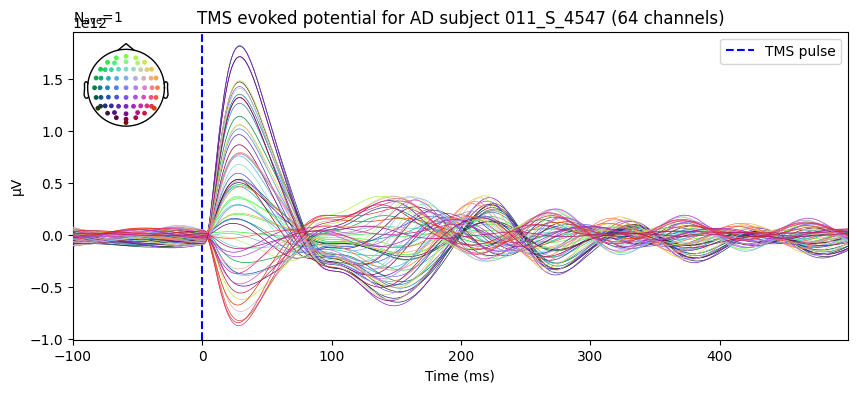

In [50]:
f, ax = plt.subplots(figsize=(10, 4))
ax.axvline(x=0, color='b', linestyle='--', label='TMS pulse')
#legend true
ax.legend()
evoked.plot(show=False, time_unit='ms', axes=ax, titles=f'TMS evoked potential for {type} subject {subject}')


In [51]:
fig = evoked.plot_topomap(times=np.array([0.03]), ch_type='eeg', time_unit='ms', show_names=False, show=True, size=4)
fig.suptitle(f'Topomap of P30 TEP for {type} subject {subject}', fontsize=16)
# fig.show()

Text(0.5, 0.98, 'Topomap of P30 TEP for AD subject 011_S_4547')

No projector specified for this dataset. Please consider the method self.add_proj.


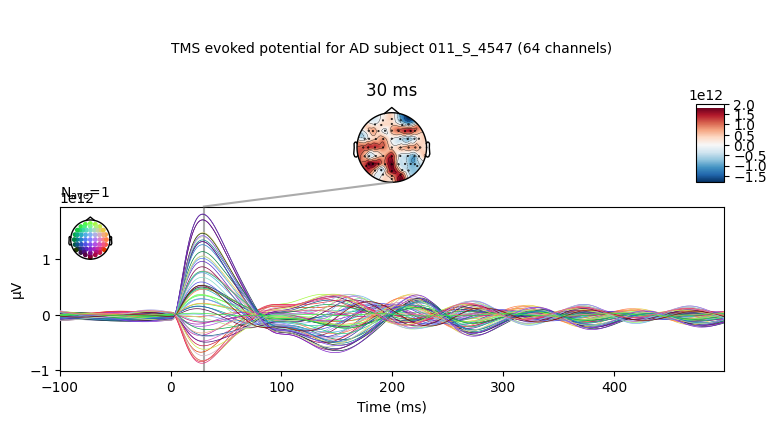

In [52]:
topomap_args=dict(ch_type='eeg', time_unit='ms', show_names=False)
ts_args=dict(time_unit='ms', show_names=False, titles=f'TMS evoked potential for {type} subject {subject}')
evoked.plot_joint(times=np.array([0.03]), show=False, ts_args=ts_args, topomap_args=topomap_args)

In [56]:
# animate 
times = np.arange(0, 0.4999, 0.01)
fig, anim = evoked.animate_topomap(
    times=times, ch_type='eeg', frame_rate=2, blit=False, show=True, time_unit='ms')
# anim.save('topomap.gif')


Using matplotlib backend: TkAgg


Initializing animation...


/home/anujanegi/anaconda3/envs/simnibs_env/lib/python3.9/site-packages/mne/viz/topomap.py:2334: UserWarning: No contour levels were found within the data range.
  cont = ax.contour(Xi, Yi, Zi, levels=cont_lims, colors='k', linewidths=1)
